<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/00-Features_Selection_by_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo 50 JAIIO

___Título:___ E-mail mining: un enfoque semi-supervisado para la identificación, el etiquetado y la clasificación de consultas académicas

___Autores:___ Nicolás Cavasin, Juan Manuel Fernandez, Marcelo Errecalde

## 0. Misceláneos:

### Descarga de librerias necesarias

In [1]:
!pip install es-lemmatizer
!python -m spacy download es
!pip install requests
!pip install wget

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/jcc/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import consolidar_df

### Descarga dataset de training ya discretizado y con 800 correos etiquetados:

In [3]:
# Descargo los correos ya etiquetados
from os import path

if not (path.exists('correos-train-80.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/consolidado_jcc/correos-train-80.csv

### Definición de funciones auxiliares

In [4]:
import nltk
from nltk.stem import SnowballStemmer
from es_lemmatizer import lemmatize
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens
    stems = []
    for item in tokens:
        stems.append(SnowballStemmer('spanish').stem(item))
    return stems

## 1. Presentación del dataset:

### 1.1 Se levanta en un DataFrame para poder manipularlo

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargo correos en un dataframe
#correos = pd.read_csv('01-Correos_Seleccionados_y_Etiquetados.csv', sep='|')
correos = pd.read_csv('correos-train-80.csv')

# Muestro forma
print(f'Shape = {len(correos)} tuplas x {correos.shape[1]} columnas.\n')

# Muestro top 5
correos.head()

Shape = 800 tuplas x 24 columnas.



,Consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
0,quisiera saber porque no tengo el numero de le...,6,1,2,1,2016,3,5,0,0,0,17,4,135,0.0,0.822222,0,23,10,0.956522,0.014815,1,0,12
1,quería cambiarme al prof. de educ. física. qui...,0,1,4,1,2016,0,3,3,1,1,55,6,259,0.0,0.795367,8,47,27,0.829787,0.023166,5,0,1
2,hola. quiero saber en que condición estoy para...,3,3,2,1,2019,0,1,1,1,1,27,4,191,0.0,0.780105,1,35,19,0.885714,0.036649,4,0,15
3,"estimados, no puedo inscribirme a las cursadas...",2,4,2,1,2018,3,1,1,1,1,6,13,242,0.0,0.805785,1,41,22,0.829268,0.028926,2,0,15
4,estoy tratando de realizar la prescripción on-...,4,4,5,1,2018,3,6,0,0,1,0,4,141,0.0,0.808511,3,26,14,0.846154,0.007092,1,0,11


### 1.2 Muestro 5 consultas

In [6]:
# Muestro por completo las primeras 5 consultas
for idx, e in enumerate(correos['Consulta'][0:5]):
    print(f'{idx+1} - {e}\n')

1 - quisiera saber porque no tengo el numero de legajo? lo necesitaria para poder anotarme en los horarios de las materias. muchas gracias 

2 - quería cambiarme al prof. de educ. física. quiero ver la oferta de asignaturas y así ver los horarios, ya que me dijeron qué tenía abril/mayo para el cambio de carrera. pero no me deja entrar porque dice que el período de inscripción no está vigente. gracias 

3 - hola. quiero saber en que condición estoy para retomar la carrera. ya estuve libre y no se si me puedo reinscribir. en caso de no poder, &iquest;como hago para no perder lo cursado? gracias. 

4 - estimados, no puedo inscribirme a las cursadas de la licenciatura en historia, ya que, al realizar los pasos correspondientes me dice que estoy en condición de libre.  a la espera de una respuesta favorable, desde ya muchas gracias, alberto. 

5 - estoy tratando de realizar la prescripción on-line y luego de llenar con los datos no me llega ningún mail para continuar con la operación.  



1.3 Escalado de los datos

In [7]:
# Escalado Min-Max
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Mantengo el tipo de dato DataFrame
correos[correos.columns.difference(['Consulta', 'clase'])] = pd.DataFrame(scaler.fit_transform(correos[correos.columns.difference(['Consulta', 'clase'])]),columns=correos.columns.difference(['Consulta', 'clase']))

correos.head()

,Consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
0,quisiera saber porque no tengo el numero de le...,1.000000,0.00,0.090909,0.0,0.25,1.0,0.571429,0.00,0.0,0.0,0.293103,0.250000,0.278618,0.0,0.710751,0.000000,0.207921,0.121622,0.935404,0.165432,0.000000,0.0,12
1,quería cambiarme al prof. de educ. física. qui...,0.000000,0.00,0.272727,0.0,0.25,0.0,0.285714,0.75,1.0,1.0,0.948276,0.416667,0.546436,0.0,0.616640,0.666667,0.445545,0.351351,0.747112,0.258687,0.235294,0.0,1
2,hola. quiero saber en que condición estoy para...,0.500000,0.50,0.090909,0.0,1.00,0.0,0.000000,0.25,1.0,1.0,0.465517,0.250000,0.399568,0.0,0.563156,0.083333,0.326733,0.243243,0.830204,0.409250,0.176471,0.0,15
3,"estimados, no puedo inscribirme a las cursadas...",0.333333,0.75,0.090909,0.0,0.75,1.0,0.000000,0.25,1.0,1.0,0.103448,1.000000,0.509719,0.0,0.653150,0.083333,0.386139,0.283784,0.746341,0.323003,0.058824,0.0,15
4,estoy tratando de realizar la prescripción on-...,0.666667,0.75,0.363636,0.0,0.75,1.0,0.714286,0.00,0.0,1.0,0.000000,0.250000,0.291577,0.0,0.662701,0.250000,0.237624,0.175676,0.771429,0.079196,0.000000,0.0,11


## 2. Análisis Exploratorio de Datos:


### 2.1 Transformación de las clases identificadas por el experto

In [8]:
from sklearn.preprocessing import LabelEncoder

clases = ['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión',
          'Carga de Notas', 'Certificados Web', 'Consulta por Equivalencias',
          'Consulta por Legajo', 'Consulta sobre Título Universitario',
          'Cursadas', 'Datos Personales', 'Exámenes',
          'Ingreso a la Universidad', 'Inscripción a Cursadas',
          'Pedido de Certificados', 'Problemas con la Clave',
          'Reincorporación', 'Requisitos de Ingreso',
          'Simultaneidad de Carreras', 'Situación Académica', 
          'Vacunas Enfermería']

# Instancio el transformador
le = LabelEncoder()

# Discretizo
clases_disc = le.fit_transform(clases)

# Muestro clases originales
print(f'Clases originales:\n{clases}\n')

# Muestro clases discretizadas
print(f'Clases discretizadas:\n{clases_disc}\n')

# Accedo a la clase original por su valor discretizado
print(f'Acceso a la original con discretizada:\n{clases[clases_disc[2]]}')

Clases originales:
['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión', 'Carga de Notas', 'Certificados Web', 'Consulta por Equivalencias', 'Consulta por Legajo', 'Consulta sobre Título Universitario', 'Cursadas', 'Datos Personales', 'Exámenes', 'Ingreso a la Universidad', 'Inscripción a Cursadas', 'Pedido de Certificados', 'Problemas con la Clave', 'Reincorporación', 'Requisitos de Ingreso', 'Simultaneidad de Carreras', 'Situación Académica', 'Vacunas Enfermería']

Clases discretizadas:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Acceso a la original con discretizada:
Cambio de Comisión


### 2.2 Creación de un dataframe con las clases originales sin discretizar

In [9]:
# Creo un nuevo dataframe
correos_clase = correos.copy()

# Aplico una transformacion inversa para des-discretizar
correos_clase['clase'] = le.inverse_transform(correos['clase'])

# Muestro las primeras 5 clases originales
correos_clase['clase'].head()

0      Inscripción a Cursadas
1           Cambio de Carrera
2             Reincorporación
3             Reincorporación
4    Ingreso a la Universidad
Name: clase, dtype: object

### 2.3 Presentación de la distribución de *clase*


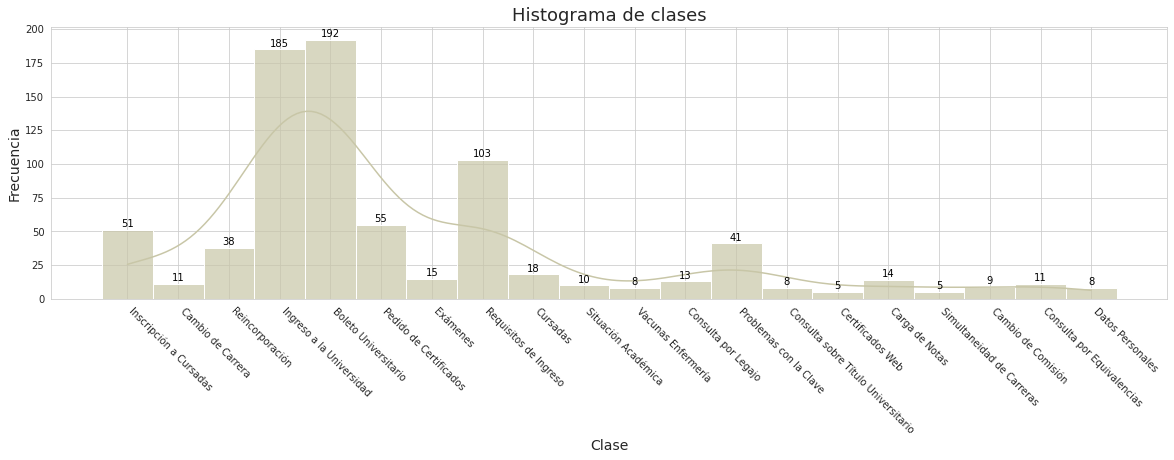

In [10]:
from matplotlib import pyplot
import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize=(20,5))
plt.tight_layout()

ax = sns.histplot(correos_clase['clase'], kde=True, stat='count', 
                  bins=correos['clase'].unique(), binwidth=0.1, 
                  color='#c8c6a7', alpha=0.7)

ax.set_xticklabels(correos_clase['clase'].unique(), 
                   rotation=-45, 
                   horizontalalignment='left', fontweight='light')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='center', color='black')

plt.title('Histograma de clases', fontsize = 18)
plt.xlabel('Clase', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.savefig('histograma.png', optimize=True, 
            transparent=True, bbox_inches = 'tight')

## 3. Pre-procesamiento:

### 3.1 Tokenización de *Consulta*

In [11]:
import warnings 
warnings.filterwarnings(action='ignore')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
from string import punctuation

# Instancio la lista de stopwords en español propuesta por nltk
stop_words_es = set(stopwords.words('spanish'))

# Instancio, tokenizo y agrego puntuacion a la lista de stop_words
punkt = set(nltk.word_tokenize(punctuation))
punkt.union({'¡', '¿'})
stop_words = stop_words_es.union(punkt)

# Agrego palabras que consideramos irrelevantes
irrelevantes = {'hola', 'chau', 'gracias', 'saludos', 'adios', 'buenas', 'buen'}

# Uno los sets
stop_words = stop_words.union(irrelevantes)

# Muestro version final de stop_words
print(f'STOPWORDS: {stop_words}')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instancio el transformador
consultas_rep = TfidfVectorizer(analyzer='word', decode_error='ignore', min_df=5,
                                strip_accents='unicode', stop_words=stop_words)

# Vectorizo y cuento las ocurrencias de Consulta
features = consultas_rep.fit_transform(correos['Consulta'])

# Muestro forma y ocurrenccias
print(f'\nShape = {features.shape[0]} tuplas x {features.shape[1]} columnas.\n')
print(f'Vocabulario <\'token\':ocurrencias>:\n{consultas_rep.vocabulary_}\n')

warnings.resetwarnings()

STOPWORDS: {'esas', 'tuviera', 'míos', 'suyos', 'hubiésemos', 'tendrá', 'sentidas', 'habré', 'tened', 'sin', 'tanto', 'estuviese', 'estada', 'habíamos', 'unos', 'hayáis', 'yo', ',', 'sentid', 'estabas', 'ya', 'el', 'sentida', 'tiene', 'mi', 'nuestro', 'entre', 'a', 'estados', 'tuviese', 'les', 'mía', 'gracias', 'algo', 'estuvieseis', 'saludos', 'estad', "''", 'le', 'quien', 'mío', 'fuera', 'tengas', 'otros', 'te', 'está', 'hubisteis', 'fueron', 'sintiendo', 'tenías', 'otras', 'eras', 'tenéis', 'soy', 'habríais', 'estuvierais', '^_`', 'habréis', 'cuando', 'estaríamos', 'un', 'tuviéramos', 'habremos', 'estas', 'vuestro', 'estuvieses', 'estará', 'suyo', 'esos', 'como', 'nuestras', 'he', 'sí', 'tuvierais', 'estaba', 'vuestros', 'habrán', 'buen', 'tuyos', 'eso', 'estuvimos', 'nada', 'habrías', 'tienes', '@', 'no', 'estés', 'estos', 'nuestros', 'habidos', 'haya', 'teníamos', 'esté', 'seas', 'estás', 'tuvimos', 'durante', 'habría', 'una', 'él', 'tengan', '!', 'fuese', 'sean', 'será', 'estaréi

In [13]:
# Almaceno vocabulario en un dataframe
vocabulario = pd.DataFrame(features.toarray(), columns=consultas_rep.get_feature_names())

### 3.2 Consolidación de features de las consultas y escalado

In [14]:
# Incorporo el TF-IDF a los atributos estáticos y los consolido en X_train
X_train, y_train = consolidar_df(correos_clase, vocabulario, 'Consulta', 'clase')

In [15]:
# Escalado Min-Max (ahora todos los atributos)
# Quiero lograr que pierdan fuerza los estáticos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Mantengo el tipo de dato DataFrame
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)

X_train.head()

,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,10,12,2016,2017,2018,22,25,abril,academica,acceder,acceso,acerca,acercarme,acredita,acreditacion,acredito,administracion,agradeceria,...,tarde,tardes,tarifa,tarjeta,tema,tendria,tener,tenia,terminal,terminales,terminar,tiempo,titulo,todavia,trabajo,tramitar,tramite,tramites,ud,ultima,universidad,universitario,unlu,urgente,usted,ustedes,usuario,va,van,varias,varios,veces,ver,vez,via,viene,viernes,volver,voy,web
0,1.000000,0.00,0.090909,0.0,0.25,1.0,0.571429,0.00,0.0,0.0,0.293103,0.250000,0.278618,0.0,0.710751,0.000000,0.207921,0.121622,0.935404,0.165432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.00,0.272727,0.0,0.25,0.0,0.285714,0.75,1.0,1.0,0.948276,0.416667,0.546436,0.0,0.616640,0.666667,0.445545,0.351351,0.747112,0.258687,0.235294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.60181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.806402,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.500000,0.50,0.090909,0.0,1.00,0.0,0.000000,0.25,1.0,1.0,0.465517,0.250000,0.399568,0.0,0.563156,0.083333,0.326733,0.243243,0.830204,0.409250,0.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333333,0.75,0.090909,0.0,0.75,1.0,0.000000,0.25,1.0,1.0,0.103448,1.000000,0.509719,0.0,0.653150,0.083333,0.386139,0.283784,0.746341,0.323003,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.666667,0.75,0.363636,0.0,0.75,1.0,0.714286,0.00,0.0,1.0,0.000000,0.250000,0.291577,0.0,0.662701,0.250000,0.237624,0.175676,0.771429,0.079196,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Evaluación de los atributos importantes por Clase

### 4.1 Evaluación de palabras más importantes por _clase_

In [73]:
df_terminos = pd.concat([X_train.iloc[:, 22:], pd.DataFrame(y_train, columns=['clase'])], axis=1).groupby(['clase']).sum().reset_index()
df_terminos.head()

,clase,10,12,2016,2017,2018,22,25,abril,academica,acceder,acceso,acerca,acercarme,acredita,acreditacion,acredito,administracion,agradeceria,aguardo,ahora,algun,alguna,alimentos,alumna,alumno,analitico,ano,anos,anotar,anotarme,anotarse,anote,anterior,aparece,aparecen,aparezco,aprobadas,aprobe,asi,...,tarde,tardes,tarifa,tarjeta,tema,tendria,tener,tenia,terminal,terminales,terminar,tiempo,titulo,todavia,trabajo,tramitar,tramite,tramites,ud,ultima,universidad,universitario,unlu,urgente,usted,ustedes,usuario,va,van,varias,varios,veces,ver,vez,via,viene,viernes,volver,voy,web
0,Boleto Universitario,0.000000,0.545753,0.000000,0.000000,1.487561,1.309716,0.791897,2.256978,0.00000,3.731926,0.0,2.960165,0.000000,4.091101,3.935372,6.71468,0.000000,1.499621,1.269199,5.701945,5.195215,3.248863,0.0,0.000000,0.981347,0.0,11.393523,1.525241,0.3916,0.262816,0.0,0.000000,1.355932,7.286071,0.000000,0.438675,0.00000,0.559282,4.283734,...,1.991092,13.055251,4.502725,9.70048,5.543649,1.0,3.485643,11.924134,5.665973,3.371927,1.65932,3.822151,0.404391,5.248645,0.000000,4.615827,23.662808,1.659313,0.0,1.838263,5.165319,4.462616,3.198937,0.880972,1.556222,4.088685,1.784098,2.489832,2.343783,0.801159,2.128749,0.0,1.348949,5.054982,0.448696,0.0,1.000000,3.742910,3.596023,2.540451
1,Cambio de Carrera,0.766074,0.000000,1.566633,0.000000,0.438518,0.000000,0.000000,0.361128,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.956982,0.000000,0.000000,0.000000,0.000000,0.519400,0.0,1.364935,0.000000,0.0,1.102347,0.000000,0.0000,0.591424,0.0,0.000000,0.000000,0.334610,0.000000,0.000000,0.00000,0.000000,1.589091,...,0.000000,1.003890,0.000000,0.00000,0.000000,0.0,0.000000,0.601810,0.000000,0.000000,0.00000,0.639557,0.000000,0.270532,0.308425,0.000000,0.000000,0.000000,0.0,0.000000,0.214979,0.000000,0.000000,0.708639,0.000000,0.589150,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.806402,0.000000,0.000000,0.0,0.000000,1.046594,0.000000,0.000000
2,Cambio de Comisión,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.690727,0.000000,0.000000,0.00000,0.786569,0.000000,0.000000,0.000000,0.000000,0.958941,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.0,0.846554,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.930249,0.855796,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.517589,0.000000,0.00000,1.391369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,Carga de Notas,0.948611,0.861354,0.000000,0.502119,0.666684,0.602138,0.000000,0.000000,1.14173,0.000000,0.0,0.850853,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.586952,0.000000,0.000000,0.000000,0.0,0.000000,0.554289,0.0,0.000000,0.000000,0.0000,0.000000,0.0,0.693542,0.000000,2.302922,1.000000,0.398853,0.29424,2.860527,0.000000,...,0.000000,1.665345,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.390550,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.361954,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382581,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.620017,0.000000,0.000000,0.799462
4,Certificados Web,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.454325,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.064169,0.0,0.000000,0.000000,0.0000,0.568378,0.0,0.000000,0.000000,0.000000,0.635386,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.739394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000

In [69]:
N = 5

for clase_iter in clases:
  # Defino la clase a tratar
  print('\nClase: {}'.format(clase_iter))

  # Transpongo la fila en columna
  terminos_clase = df_terminos[df_terminos['clase']==clase_iter].transpose().reset_index()

  # Renombro las columnas
  terminos_clase.columns = ['termino', 'valor']

  # Elimino el valor de la clase
  terminos_clase = terminos_clase.loc[terminos_clase['termino']!='clase']

  # Paso a numérica la columna
  terminos_clase['valor'] = pd.to_numeric(terminos_clase['valor'])

  # Muestro los N más importantes para la clase
  print('{} términos más importantes:\n {}'.format(N, terminos_clase.nlargest(N,'valor')))


Clase: Boleto Universitario
5 términos más importantes:
          termino      valor
56        boleto  55.763111
161  estudiantil  46.279938
54     beneficio  40.525438
385         sube  37.096895
356        saber  26.915663

Clase: Cambio de Carrera
5 términos más importantes:
        termino     valor
66     carrera  3.648968
60   cambiarme  2.363518
61      cambio  1.917362
175     fisica  1.782014
39         asi  1.589091

Clase: Cambio de Comisión
5 términos más importantes:
       termino     valor
76   comision  3.165205
61     cambio  2.118128
193  horarios  2.068695
356     saber  1.826241
307   posible  1.606352

Clase: Carga de Notas
5 términos más importantes:
     termino     valor
264    nota  7.064886
173   final  4.409395
38   aprobe  2.860527
349   rendi  2.486406
253  muchas  2.456449

Clase: Certificados Web
5 términos más importantes:
         termino     valor
25       alumno  2.064169
84   constancia  1.642577
253      muchas  1.635289
327      queria  1.626038
3

In [71]:
# Se importan las librerías
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(10, 8))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

#freqs = [(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

# Genera la wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(terminos_clase)
plot_cloud(wordcloud)

TypeError: ignored

### 4.2 Prueba de Chi-cuadrado

In [18]:
def topK_chi2(X, y, clase, N):
  '''
  Calcula la importancia de cada variable para la clase
  '''
  return 0

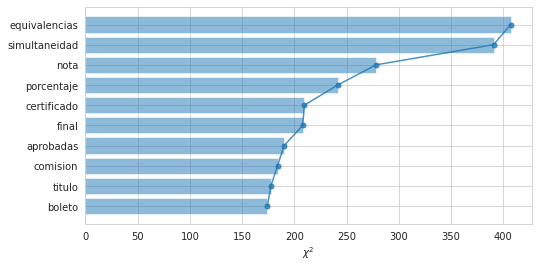

In [74]:
# Analizo cuales son las features mas importantes según chi2
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
%matplotlib inline

# Inicializo el tamaño del gráfico
plt.figure(figsize=(8,4))

# chi2[0]: devuelve el score por cada feature
# chi2[1]: devuelve el p-value por score
chi2score = chi2(X_train, y_train)[0]

# Los paso a clave valor (feature, score_chi2)
scores = list(zip(X_train.columns, chi2score))

# Ordeno los scores (de menor a mayor)
chi2 = sorted(scores, key=lambda x:x[1])

# Me quedo con los últimos N (los mas grandes)
N=10
topchi2 = list(zip(*chi2[-N:]))

# Convierto en intervalo el total para la cantidad de barras del gráfico
x_chi = range(len(topchi2[1]))

# Tomo los labels
labels = topchi2[0]

# Grafico en función de los scores
plt.barh(x_chi, topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x_chi, '-o', markersize=5, alpha=0.8)
plt.yticks(x_chi, labels)

# Pongo el xlabel
plt.xlabel(r'$\chi^2$')

# Muestro el gráfico
plt.show();

# Referencias:
1. [Presentación](0) de apoyo al [Proyecto de Investigación](1) "Clasificación automática de correos electrónicos".

2. Clasificacion de textos por etiquetado de palabras: [short paper](2).

3. [API](3) del diccionario Collins.

4. [Funciones](4) de la [API](3) del diccionario Collins.

5. Librería [clusteval](5) para la evaluación KMeans.

[0]:https://docs.google.com/presentation/d/1-gdZ3dUI2pAfXM6Bgau53U7G4g2Bkv6DlxGESnu7A20/edit?usp=sharing 
[1]:https://github.com/jumafernandez/clasificacion_correos 
[2]:https://www.aaai.org/Papers/AAAI/2004/AAAI04-068.pdf
[3]:https://pypi.org/project/collins-client/
[4]:https://api.collinsdictionary.com/api/v1/documentation/html
[5]:https://clusteval.sdu.dk/1/mains

# Papers:
1. Ali, R. S. H., & El Gayar, N. (2019, December). Sentiment Analysis using Unlabeled Email data. In 2019 International Conference on Computational Intelligence and Knowledge Economy (ICCIKE) (pp. 328-333). IEEE.
1. Gupta, I., & Joshi, N. (2020). Real-time twitter corpus labelling using automatic clustering approach. International Journal of Computing and Digital Systems, 9, 1-9.
1. Liu, B., Li, X., Lee, W. S., & Yu, P. S. (2004, July). Text classification by labeling words. In AAAI (Vol. 4, pp. 425-430).
1. Liu, S., & Lee, I. (2018). Email sentiment analysis through k-means labeling and support vector machine classification. Cybernetics and Systems, 49(3), 181-199.
